In [96]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
data_dir = 'kaggle-survey-2018/'

In [3]:
multiple_choice = pd.read_csv(data_dir + 'multipleChoiceResponses.csv', low_memory=False)

In [4]:
def convert_salary(salary):

    if salary == '500,000+':
        return 500000
    else:
        try:
            a, b = salary.replace(',','').split('-')
            avg = (int(a)*1000+int(b))/2
            return avg
        except:
            return None

In [5]:
def convert_xp(xp, return_type):
    if xp == '30 +':
        xp = 30
    elif xp == '40+ years':
        xp = 40
    elif xp == '< 1 year':
        xp = 0.5
    else:
        try:
            a, b = xp.replace(' years', '').split('-')
            xp = (int(a)+int(b))/2
        except:
            return None
        
    if return_type == 'years':
        return xp
    elif return_type == 'seniority level':
        if xp < 3:
            return 0
        elif xp < 6:
            return 1
        else:
            return 2
    else:
        return None   

In [6]:
def convert_age(age):
    if age == '80+':
        return 80
    else:
        try:
            a, b = age.split('-')
            return (int(a)+int(b))/2
        except:
            return None

In [7]:
df = pd.DataFrame()
df['gender'] = multiple_choice.Q1
df['current_role_xp'] = multiple_choice.Q8.apply(convert_xp, args = ('years',))
df['coding_xp'] = multiple_choice.Q24.apply(convert_xp, args = ('years',))
df['ml_xp'] = multiple_choice.Q25.apply(convert_xp, args = ('years',))
df['current_role_xp_level'] = multiple_choice.Q8.apply(convert_xp, args = ('seniority level',))
df['coding_xp_level'] = multiple_choice.Q24.apply(convert_xp, args = ('seniority level',))
df['ml_xp_level'] = multiple_choice.Q25.apply(convert_xp, args = ('seniority level',))
df['income'] = multiple_choice.Q9.apply(convert_salary)
df['geography'] = multiple_choice.Q3
df['original_age'] = multiple_choice.Q2
df['age'] = multiple_choice.Q2.apply(convert_age)

df = df[df.gender.isin(['Male', 'Female'])]

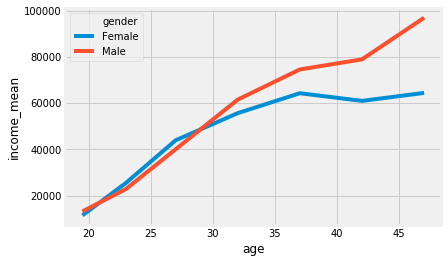

In [35]:
df_plot = sqldf("""
with bd as (
    select gender, age, avg(income) as income_mean, sum(case when income is not null then 1 else 0 end) as income_count
    from df
    group by 1, 2
)
, fl as (
    select *
    from bd
    where gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from bd
    where gender = 'Male'
    and income_count >= 50
)
, ages as (
    select distinct fl.age
    from fl
    join ml on fl.age = ml.age
)
select *
from fl
where age in (select * from ages)
UNION ALL
select *
from ml
where age in (select * from ages)
""")

sns.lineplot(x = 'age', y='income_mean', hue='gender', data=df_plot)
plt.show()

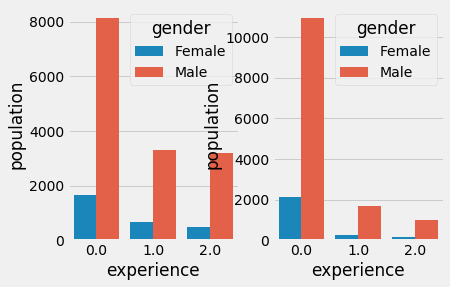

In [63]:
df_plot = sqldf("""
select gender, coding_xp_level as experience, 'coding_xp' as dimension, count(*) as population
from df
where coding_xp_level is not null
group by 1, 2
UNION ALL
select gender, ml_xp_level as experience, 'ml_xp' as dimension, count(*) as population
from df
where ml_xp_level is not null
group by 1, 2
""")

fix, axs = plt.subplots(ncols=2)
sns.barplot(x='experience', y='population', hue='gender', data=df_plot[df_plot['dimension']=='coding_xp'], ax=axs[0])
sns.barplot(x='experience', y='population', hue='gender', data=df_plot[df_plot['dimension']=='ml_xp'], ax=axs[1])
plt.show()

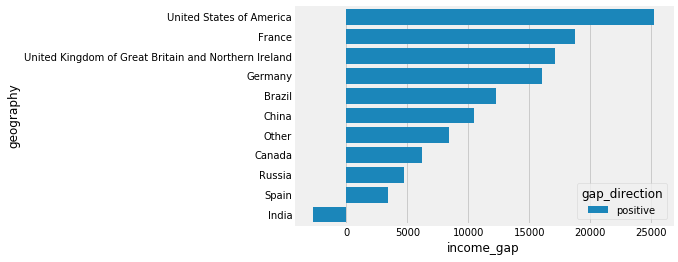

In [100]:
df_plot = sqldf("""
with bd as (
    select gender, geography, avg(income) as income_mean, sum(case when income is not null then 1 else 0 end) as income_count
    from df
    group by 1, 2
)
, fl as (
    select *
    from bd
    where gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from bd
    where gender = 'Male'
    and income_count >= 50
)
, geos as (
    select distinct fl.geography
    from fl
    join ml on fl.geography = ml.geography
)
select fl.geography, (ml.income_mean-fl.income_mean) as income_gap, case when (ml.income_mean-fl.income_mean) > 0 then 'positive' else 'positive' end as gap_direction
from fl
join ml on fl.geography = ml.geography
where fl.geography in (select * from geos)
order by (ml.income_mean-fl.income_mean) desc
"""
)

sns.barplot(x='income_gap', y='geography', hue = 'gap_direction', data=df_plot)
plt.show()

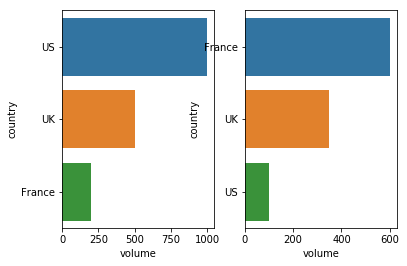

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

d = {'volume' : [1000, 500, 200, 100, 350, 600], 'year' : [2017, 2017, 2017, 2018, 2018, 2018], 'country' : ['US', 'UK', 'France', 'US', 'UK', 'France']}
df = pd.DataFrame(data=d)

fix, axs = plt.subplots(ncols=2)
sns.barplot(x='volume',y='country', data=df[df['year']==2017].sort_values(by='volume', ascending = False), ax=axs[0])
sns.barplot(x='volume',y='country', data=df[df['year']==2018].sort_values(by='volume', ascending = False), ax=axs[1])
plt.show()

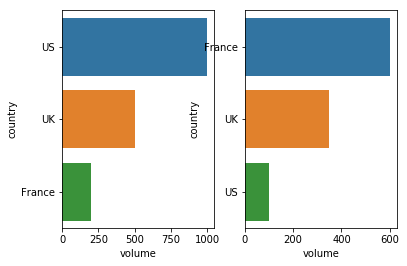